<a href="https://colab.research.google.com/github/bundickm/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [40]:
import numpy as np
import scipy
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 2], [1, 2]])
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [41]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=34.857949898913425, pvalue=2.695829082915324e-08)


In [42]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [43]:
import pandas as pd

gender = ['male','male','male','female','female','female']
eats_outside = ['outside','inside', 'inside','inside','outside','outside']

df = pd.DataFrame({'Gender':gender,'Preference':eats_outside})
df.head(6)

,Gender,Preference
0,male,outside
1,male,inside
2,male,inside
3,female,inside
4,female,outside
5,female,outside


In [44]:
table = pd.crosstab(df['Gender'],df['Preference'])
table

Preference,inside,outside
Gender,,
female,1,2
male,2,1


In [45]:
pd.crosstab(df['Gender'],df['Preference'],margins=True)

Preference,inside,outside,All
Gender,,,
female,1,2,3
male,2,1,3
All,3,3,6


In [46]:
df = df.replace({'male':0,'female':1,'outside':0,'inside':1})
df

,Gender,Preference
0,0,0
1,0,1
2,0,1
3,1,1
4,1,0
5,1,0


In [0]:
pd.crosstab(df['Gender'], df['Preference'], margins=True)

expected = np.array([[1.5,1.5],
                     [1.5,1.5]])

In [48]:
pd.crosstab(df['Gender'], df['Preference'], margins=True, normalize='all')

#observed is a table of the marginal proportions of each subgroup
observed = np.array([[.5,.5],
                     [.5,.5]])

deviation = numerator = (observed - expected)
deviation_sqr = deviation**2

fraction = (deviation_sqr / expected)

chi2 = fraction.sum()
chi2_normalized = chi2/4

chi2_normalized

0.6666666666666666

In [49]:
chi_data =[[1,2],
           [2,1]]
scipy.stats.chisquare(chi_data, axis=None)

Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)

In [50]:
#not working as expected
table2 = [[1.5,1.5],
          [1.5,1.5]]
chi2stat, pvalue, dof, observed = scipy.stats.chi2_contingency(table2)
print(chi2stat)
print(pvalue)
print(dof)
print(observed)


0.0
1.0
1
[[1.5 1.5]
 [1.5 1.5]]


##Confidence Intervals

In [51]:
#confidence interval = [lower bound, upper bound]
coinflips = np.random.binomial(n=1, p=.5, size=100)
coinflips

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s


## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
import pandas as pd
import scipy
from google.colab import files
upload = files.upload()

In [0]:
#import and clean
votes = pd.read_csv('house-votes-84.data', index_col=False, 
                    names = ['Class Name',
                             'handicapped-infants',
                             'water-project-cost-sharing',
                             'physician-fee-freeze',
                             'el-salvador-aid',
                             'religious-groups-in-schools',
                             'anti-satellite-test-ban',
                             'aid-to-nicaraguan-contras',
                             'mx-missile',
                             'immigration',
                             'synfuels-corporation-cutback',
                             'education-spending',
                             'superfund-right-to-sue',
                             'crime',
                             'duty-free-exports',
                             'export-administration-act-south-africa'])

votes = votes.replace({'y':1,'n':-1,'?':0})
votes = votes.set_index('Class Name')

Running through manually calculating a confidence interval to understand what's happening

In [160]:
data = np.array(votes['handicapped-infants']) #changed the starting array a lot
data

array([-1, -1,  0, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,
        1,  1,  0,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1,
        1, -1, -1, -1,  1, -1, -1, -1,  0,  1,  0, -1,  1,  0, -1,  1, -1,
        1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1

In [161]:
mean = np.mean(data)
mean

-0.11264367816091954

In [162]:
n = len(data)
n

435

In [163]:
#The standard error of measurement (SEm) is a measure of how much measured test scores are spread around a “true” score
stderr = scipy.stats.sem(data)
stderr

0.047024976079582614

In [164]:
#stats.t.ppf - I don't fully understand what this is doing
confidence = .95
interval = stderr * scipy.stats.t.ppf((1+confidence)/2.,n-1)
interval

0.09242500709719055

In [165]:
#lower boundary
mean-interval

-0.2050686852581101

In [166]:
#upper boundary
mean+interval

-0.020218671063728988

Modified confidence_interval to spit out only interval

In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (interval)

In [168]:
#Use modified confidence_interval function to make a list of intervals
intervals = [confidence_interval(votes[column]) for column in votes]
print(intervals)
  

[0.09242500709719055, 0.08898468946640066, 0.09143028055398933, 0.09189828316190697, 0.09269942572582386, 0.08943393418559965, 0.09198679129780005, 0.09165842242181092, 0.09192745421513823, 0.09357818950870879, 0.08865581271130886, 0.0899206987418562, 0.09157678829284585, 0.09092211135637694, 0.09035592011746293]


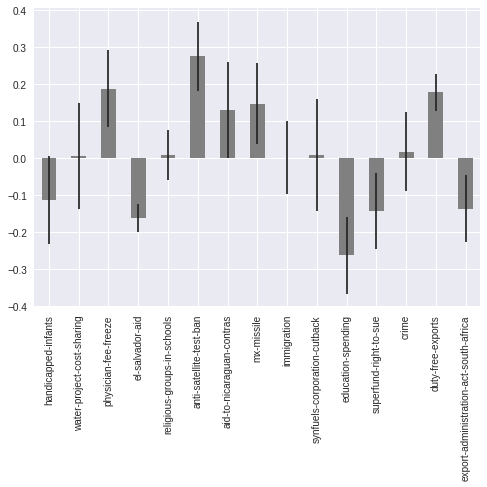

In [213]:
#Plot vote results (Positive = majority yes votes)
#Add error bar with intervals list
import matplotlib.pyplot as plt

votes.mean().plot.bar(yerr=intervals, color='grey');

#Any votes where the error bar crosses x=0 are votes that are in contention...
#and that may be worth revisting to flip

We can possibly flip the votes of 'handicapped-infants', water project cost sharing', 'religious groups in schools', 'immigration', and 'synfuels corporation cutback'. This may be useful for any actor (political party, lobbying group, etc.) looking to revist an issue for a different outcome

In [0]:
dems = votes[votes.index == 'democrat']
reps = votes[votes.index == 'republican']

0.10185137935840852
handicapped-infants                       0.202247
water-project-cost-sharing                0.003745
physician-fee-freeze                      0.756554
el-salvador-aid                          -0.865169
religious-groups-in-schools              -0.543071
anti-satellite-test-ban                  -0.044944
aid-to-nicaraguan-contras                 0.528090
mx-missile                                0.647940
immigration                               0.479401
synfuels-corporation-cutback             -0.056180
education-spending                        0.011236
superfund-right-to-sue                   -0.662921
crime                                    -0.397004
duty-free-exports                        -0.288390
export-administration-act-south-africa    0.258427
dtype: float64


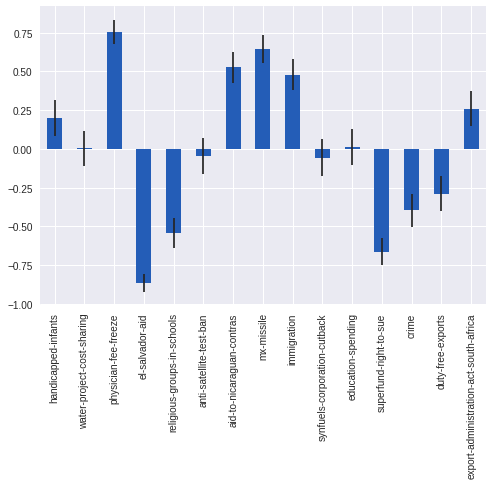

In [210]:
#can we flip dems?
intervals = [confidence_interval(dems[column]) for column in votes]
dems.mean().plot.bar(yerr=intervals, color='#245db7');
print(np.mean(intervals))
print(dems.mean())

We can flip Democrats on 4 issues. Two of these align with issues that can be flipped, giving a potential party to target our efforts on for those issues.

0.10035918961961028
handicapped-infants                      -0.613095
water-project-cost-sharing                0.011905
physician-fee-freeze                     -0.714286
el-salvador-aid                           0.958333
religious-groups-in-schools               0.886905
anti-satellite-test-ban                   0.785714
aid-to-nicaraguan-contras                -0.500000
mx-missile                               -0.648810
immigration                              -0.755952
synfuels-corporation-cutback              0.113095
education-spending                       -0.696429
superfund-right-to-sue                    0.684524
crime                                     0.678571
duty-free-exports                         0.922619
export-administration-act-south-africa   -0.761905
dtype: float64


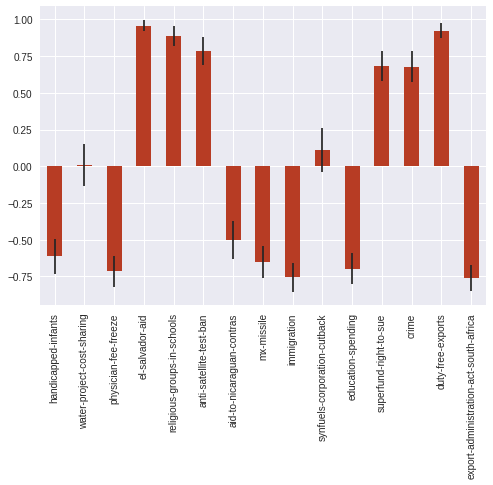

In [212]:
#can we flip reps?
intervals = [confidence_interval(reps[column]) for column in votes]
reps.mean().plot.bar(yerr=intervals, color='#b73c24');
print(np.mean(intervals))
print(reps.mean())

Republicans are better about voting as a block and can only be flipped on 2 issues. Those two issues are both flippable issues.

In [208]:
#Getting an average magnitude of votes,...
#smaller magnitude means more contention within the group

#Republicans are better at voting as a party than Democrats
print('Republicans:',np.mean(np.abs(reps.mean())))
print('Democrats:',np.mean(np.abs(dems.mean())))

#As expected, congress is divided most of the time.
print('Congress:',np.mean(np.abs(votes.mean())))

Republicans: 0.6488095238095238
Democrats: 0.3830212234706617
Congress: 0.11877394636015325


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)